# KSCU Wallet Share Analysis - Exploratory Data Analysis

## Competition Overview
- **Goal**: Predict member state transitions and wallet share for retail banking
- **States**: STAY (high wallet share), SPLIT (mixed), LEAVE (low/no wallet share)
- **Dataset**: 5,000 customers x 4 quarters = 20,000 records
- **Deadline**: September 25, 2025

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading and Overview

In [2]:
# Load the dataset (it's actually CSV despite .xls extension)
df = pd.read_csv('../data/raw/KSCU_wallet_share_train.xls')

print(f"Dataset shape: {df.shape}")
print(f"Unique customers: {df['customer_id'].nunique():,}")
print(f"Time periods: {sorted(df['quarter'].unique())}")
print(f"\nColumns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2}. {col}")

Dataset shape: (20000, 20)
Unique customers: 5,000
Time periods: ['t0', 't1', 't2', 't3']

Columns (20):
 1. customer_id
 2. age
 3. tenure_years
 4. product_count
 5. avg_balance
 6. has_mortgage
 7. salary_deposit_flag
 8. digital_engagement
 9. branch_visits_last_q
10. complaints_12m
11. nps_bucket
12. promo_exposure
13. fee_events_12m
14. rate_sensitivity
15. card_spend_monthly
16. quarter
17. state
18. wallet_share
19. next_state
20. wallet_share_next


In [3]:
# Display first few rows
df.head()

,customer_id,age,tenure_years,product_count,avg_balance,has_mortgage,salary_deposit_flag,digital_engagement,branch_visits_last_q,complaints_12m,nps_bucket,promo_exposure,fee_events_12m,rate_sensitivity,card_spend_monthly,quarter,state,wallet_share,next_state,wallet_share_next
0,1,23,4.200,7,10637.522,1,1,1.000,1,0,-1,0,0,0.492,318.551,t0,LEAVE,0.038,SPLIT,0.512
1,2,69,8.260,3,22015.791,1,0,0.490,3,0,1,0,1,0.245,1082.128,t0,SPLIT,0.448,STAY,0.865
2,3,61,3.770,2,22394.189,0,0,0.840,3,0,1,0,3,0.422,570.154,t0,STAY,0.890,STAY,0.866
3,4,47,7.300,2,6112.651,1,1,0.893,2,0,1,0,2,0.435,3420.683,t0,SPLIT,0.400,STAY,0.936
4,5,47,4.100,2,137971.754,0,1,0.400,4,1,0,1,3,0.379,1907.244,t0,STAY,0.987,STAY,0.894


In [4]:
# Data types and missing values
info_df = pd.DataFrame({
    'Data Type': df.dtypes,
    'Non-Null Count': df.count(),
    'Null Count': df.isnull().sum(),
    'Unique Values': df.nunique()
})
info_df

,Data Type,Non-Null Count,Null Count,Unique Values
customer_id,int64,20000,0,5000
age,int64,20000,0,67
tenure_years,float64,20000,0,1322
product_count,int64,20000,0,7
avg_balance,float64,20000,0,5000
has_mortgage,int64,20000,0,2
salary_deposit_flag,int64,20000,0,2
digital_engagement,float64,20000,0,4634
branch_visits_last_q,int64,20000,0,10
complaints_12m,int64,20000,0,5


## 2. State Distribution Analysis

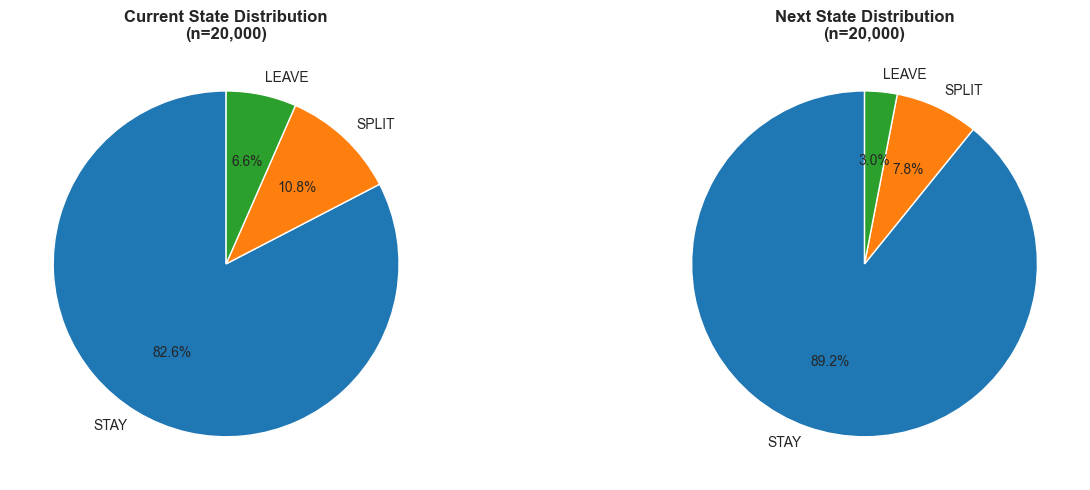

State Transition Summary:
Current State Distribution:
  STAY : 16,524 (82.6%)
  SPLIT: 2,163 (10.8%)
  LEAVE: 1,313 (6.6%)

Next State Distribution:
  STAY : 17,836 (89.2%)
  SPLIT: 1,557 (7.8%)
  LEAVE:   607 (3.0%)


In [5]:
# Current and next state distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Current state
state_counts = df['state'].value_counts()
ax1.pie(state_counts.values, labels=state_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Current State Distribution\n(n=20,000)', fontsize=12, fontweight='bold')

# Next state
next_state_counts = df['next_state'].value_counts()
ax2.pie(next_state_counts.values, labels=next_state_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Next State Distribution\n(n=20,000)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("State Transition Summary:")
print("="*40)
print(f"Current State Distribution:")
for state, count in state_counts.items():
    print(f"  {state:5}: {count:5,} ({count/len(df)*100:.1f}%)")
print(f"\nNext State Distribution:")
for state, count in next_state_counts.items():
    print(f"  {state:5}: {count:5,} ({count/len(df)*100:.1f}%)")

Transition Probability Matrix (%)
next_state  LEAVE  SPLIT   STAY
state                          
LEAVE      33.400  4.100 62.500
SPLIT       1.300 25.300 73.400
STAY        0.900  5.800 93.400

Transition Count Matrix
next_state  LEAVE  SPLIT   STAY
state                          
LEAVE         438     54    821
SPLIT          28    548   1587
STAY          141    955  15428


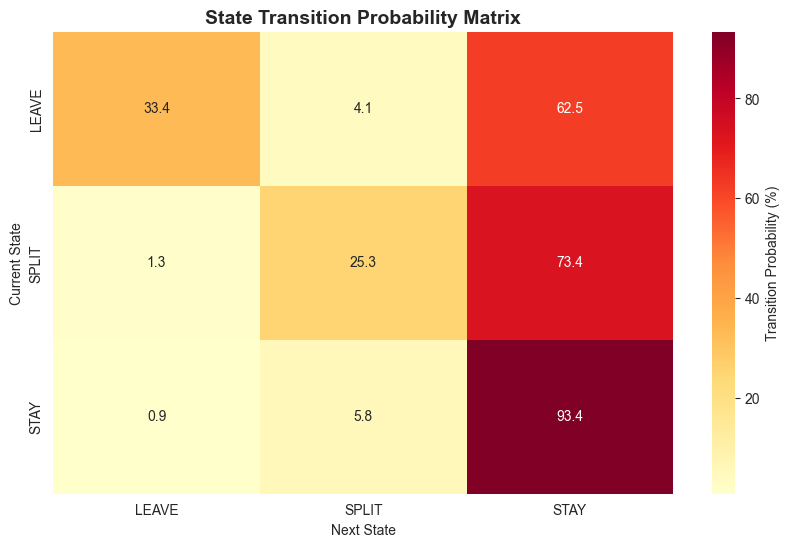

In [6]:
# Transition Matrix
transition_matrix = pd.crosstab(df['state'], df['next_state'], normalize='index') * 100
transition_counts = pd.crosstab(df['state'], df['next_state'])

print("Transition Probability Matrix (%)")
print("="*40)
print(transition_matrix.round(1))
print("\nTransition Count Matrix")
print("="*40)
print(transition_counts)

# Visualize transition matrix
plt.figure(figsize=(10, 6))
sns.heatmap(transition_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Transition Probability (%)'})
plt.title('State Transition Probability Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.show()

## 3. Wallet Share Analysis

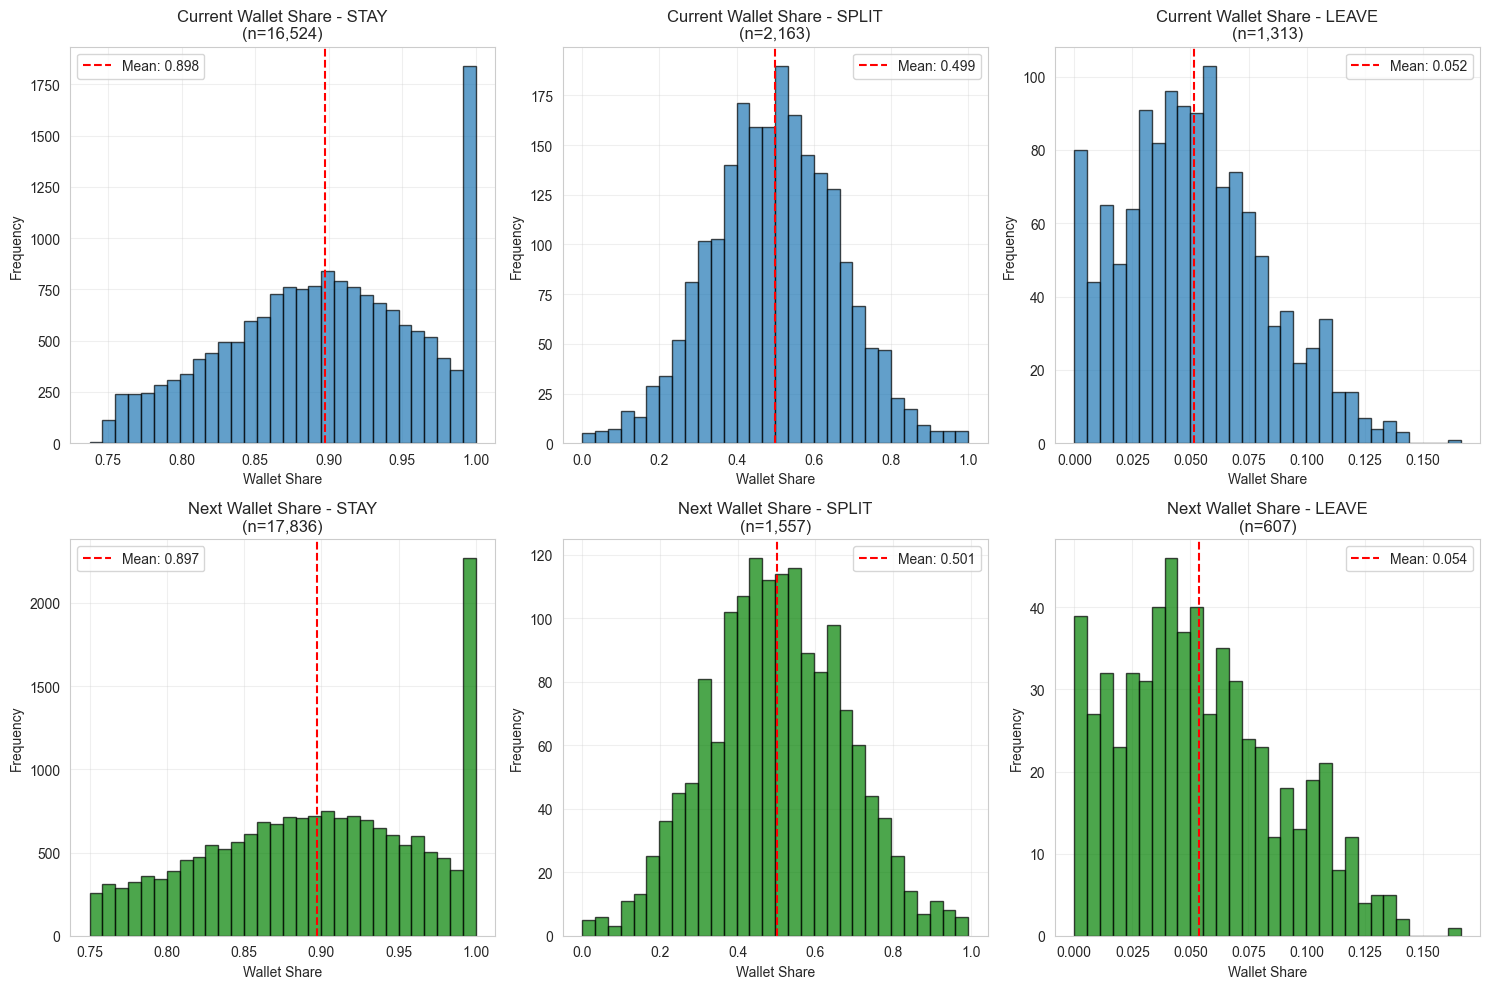

In [7]:
# Wallet share distribution by state
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Current wallet share by state
for i, state in enumerate(['STAY', 'SPLIT', 'LEAVE']):
    ax = axes[0, i]
    data = df[df['state'] == state]['wallet_share']
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.3f}')
    ax.set_title(f'Current Wallet Share - {state}\n(n={len(data):,})')
    ax.set_xlabel('Wallet Share')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Next wallet share by next state
for i, state in enumerate(['STAY', 'SPLIT', 'LEAVE']):
    ax = axes[1, i]
    data = df[df['next_state'] == state]['wallet_share_next']
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='green')
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.3f}')
    ax.set_title(f'Next Wallet Share - {state}\n(n={len(data):,})')
    ax.set_xlabel('Wallet Share')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Wallet share statistics by state
wallet_stats = df.groupby('state')['wallet_share'].agg([
    'count', 'mean', 'std', 'min', 'max',
    ('q25', lambda x: x.quantile(0.25)),
    ('median', lambda x: x.quantile(0.5)),
    ('q75', lambda x: x.quantile(0.75))
])

print("Wallet Share Statistics by Current State")
print("="*50)
print(wallet_stats.round(3))

# Define state thresholds based on data
print("\n" + "="*50)
print("Suggested State Assignment Thresholds:")
print("="*50)
print(f"LEAVE: wallet_share < 0.20")
print(f"SPLIT: 0.20 <= wallet_share < 0.80")
print(f"STAY:  wallet_share >= 0.80")

Wallet Share Statistics by Current State
       count  mean   std   min   max   q25  median   q75
state                                                   
LEAVE   1313 0.052 0.031 0.000 0.166 0.029   0.049 0.071
SPLIT   2163 0.499 0.164 0.000 1.000 0.388   0.500 0.608
STAY   16524 0.898 0.066 0.738 1.000 0.850   0.900 0.949

Suggested State Assignment Thresholds:
LEAVE: wallet_share < 0.20
SPLIT: 0.20 <= wallet_share < 0.80
STAY:  wallet_share >= 0.80


## 4. Feature Analysis

In [9]:
# Numerical features statistics
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [f for f in numerical_features if f not in ['customer_id']]

df[numerical_features].describe().round(3)

,age,tenure_years,product_count,avg_balance,has_mortgage,salary_deposit_flag,digital_engagement,branch_visits_last_q,complaints_12m,nps_bucket,promo_exposure,fee_events_12m,rate_sensitivity,card_spend_monthly,wallet_share,wallet_share_next
count,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,50.911,6.012,4.039,31139.876,0.510,0.494,0.594,1.791,0.153,0.140,0.504,2.017,0.497,2724.515,0.799,0.841
std,19.385,3.458,2.006,27765.541,0.500,0.500,0.260,1.336,0.395,0.794,0.500,1.436,0.198,3124.982,0.247,0.193
min,18.000,0.260,1.000,1141.304,0.000,0.000,0.002,0.000,0.000,-1.000,0.000,0.000,0.000,79.298,0.000,0.000
25%,34.000,3.510,2.000,13101.467,0.000,0.000,0.389,1.000,0.000,-1.000,0.000,1.000,0.363,968.082,0.803,0.820
50%,51.000,5.370,4.000,22566.378,1.000,0.000,0.597,2.000,0.000,0.000,1.000,2.000,0.497,1757.974,0.880,0.887
75%,68.000,7.810,6.000,39307.752,1.000,1.000,0.806,3.000,0.000,1.000,1.000,3.000,0.631,3317.788,0.937,0.947
max,84.000,33.620,7.000,284985.729,1.000,1.000,1.000,9.000,4.000,1.000,1.000,10.000,1.000,58764.404,1.000,1.000


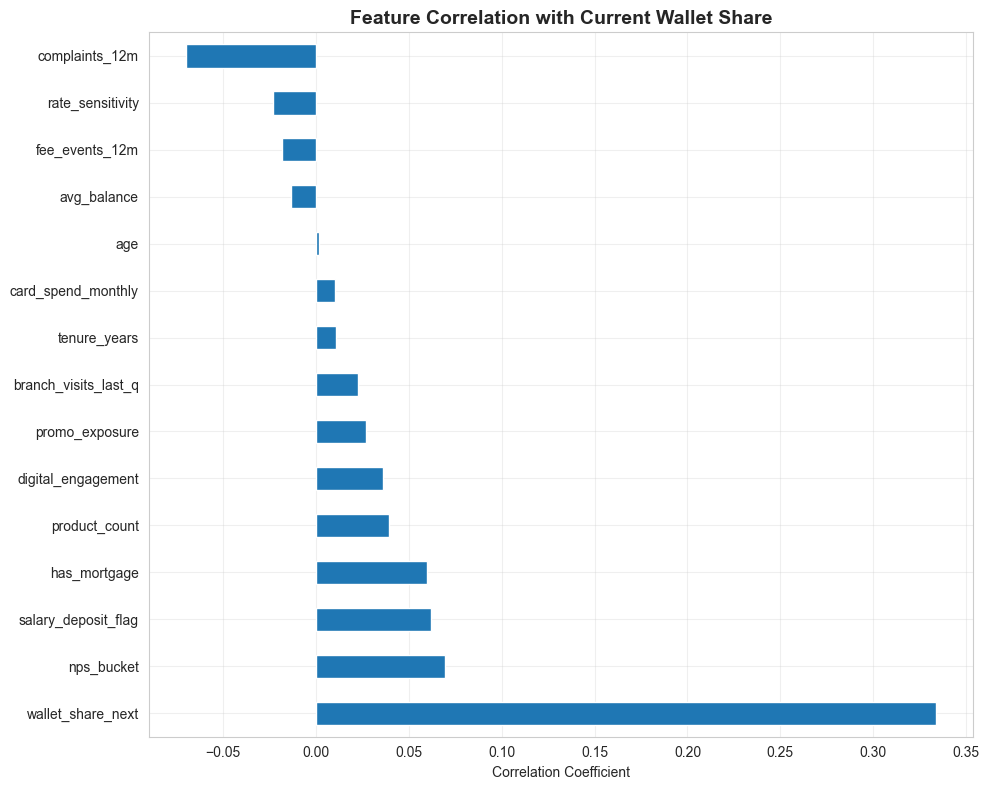

Top Positive Correlations:
wallet_share          1.000
wallet_share_next     0.334
nps_bucket            0.069
salary_deposit_flag   0.062
has_mortgage          0.060
product_count         0.039
Name: wallet_share, dtype: float64

Top Negative Correlations:
age                 0.001
avg_balance        -0.014
fee_events_12m     -0.018
rate_sensitivity   -0.023
complaints_12m     -0.070
Name: wallet_share, dtype: float64


In [10]:
# Feature correlation with wallet share
correlations = df[numerical_features].corr()['wallet_share'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
correlations.drop('wallet_share').plot(kind='barh')
plt.title('Feature Correlation with Current Wallet Share', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Top Positive Correlations:")
print(correlations.head(6))
print("\nTop Negative Correlations:")
print(correlations.tail(5))

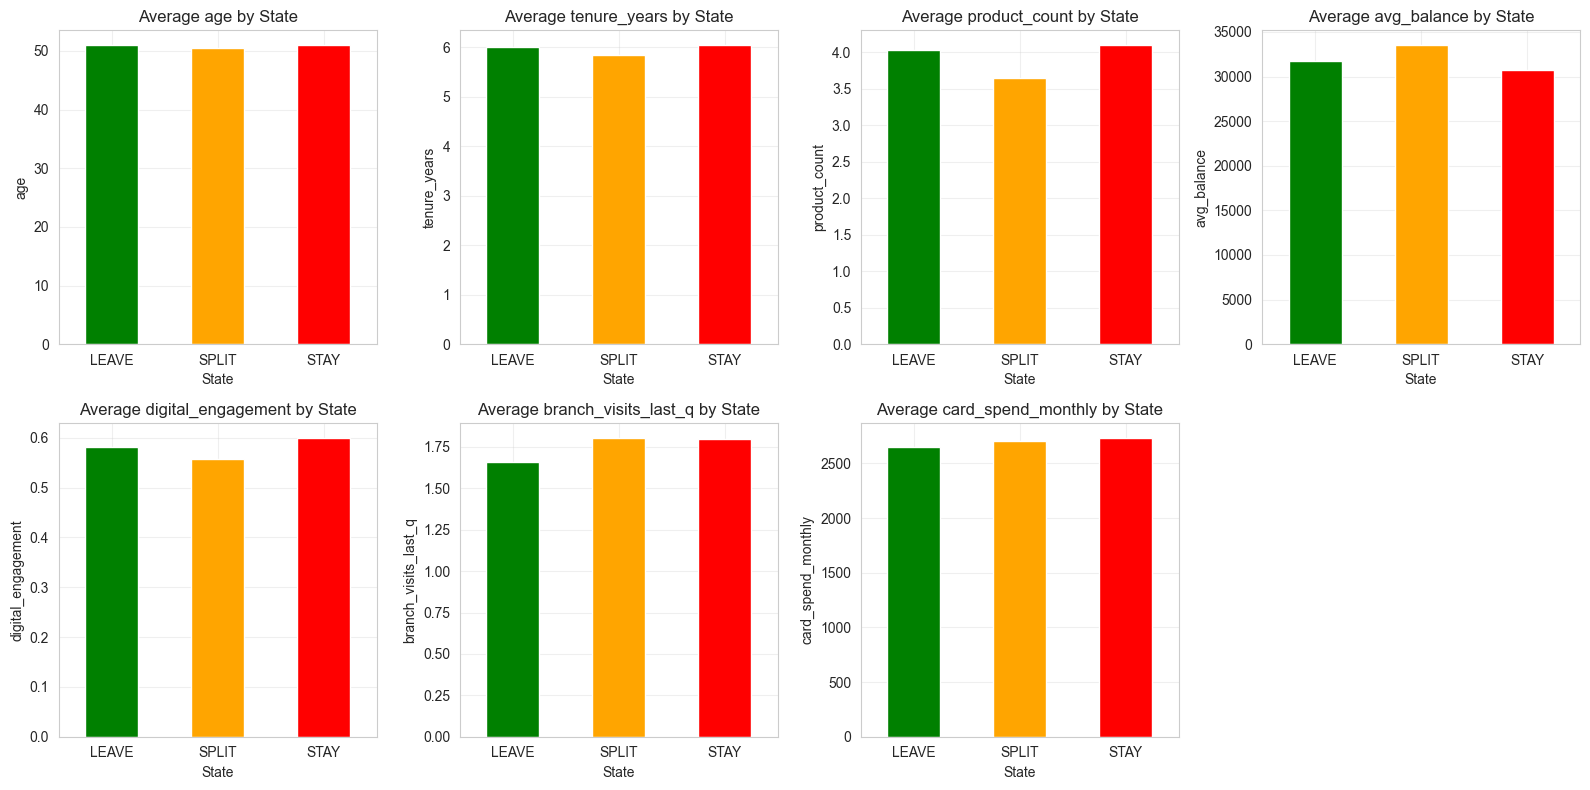

Average Feature Values by State
         age  tenure_years  product_count  avg_balance  digital_engagement  \
state                                                                        
LEAVE 50.940         6.000          4.030    31760.150               0.580   
SPLIT 50.550         5.840          3.640    33491.620               0.560   
STAY  50.960         6.040          4.090    30782.740               0.600   

       branch_visits_last_q  card_spend_monthly  
state                                            
LEAVE                 1.660            2653.190  
SPLIT                 1.800            2703.170  
STAY                  1.800            2732.980  


In [11]:
# Key features by state
key_features = ['age', 'tenure_years', 'product_count', 'avg_balance', 
                'digital_engagement', 'branch_visits_last_q', 'card_spend_monthly']

feature_by_state = df.groupby('state')[key_features].mean()

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    ax = axes[i]
    feature_by_state[feature].plot(kind='bar', ax=ax, color=['green', 'orange', 'red'])
    ax.set_title(f'Average {feature} by State')
    ax.set_xlabel('State')
    ax.set_ylabel(feature)
    ax.grid(True, alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Remove last empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

print("Average Feature Values by State")
print("="*50)
print(feature_by_state.round(2))

## 5. Temporal Analysis

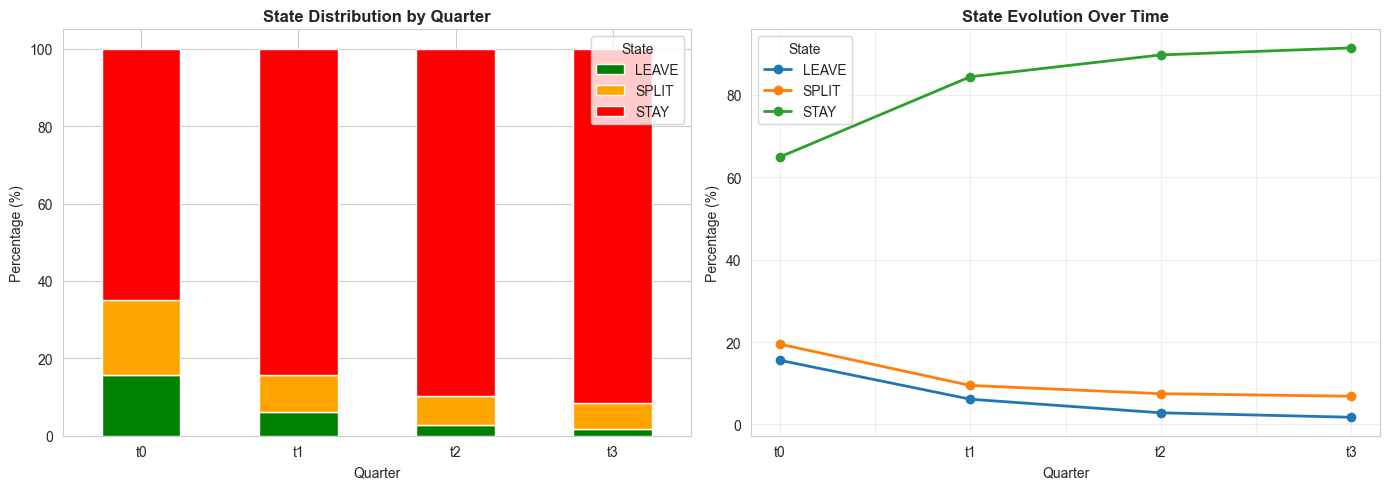

State Distribution by Quarter (%)
state    LEAVE  SPLIT   STAY
quarter                     
t0      15.600 19.500 64.900
t1       6.100  9.500 84.400
t2       2.800  7.500 89.700
t3       1.700  6.800 91.400


In [12]:
# State transitions over time
quarters = sorted(df['quarter'].unique())

# State distribution by quarter
state_by_quarter = pd.crosstab(df['quarter'], df['state'], normalize='index') * 100

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
state_by_quarter.plot(kind='bar', stacked=True, ax=ax1, 
                      color=['green', 'orange', 'red'])
ax1.set_title('State Distribution by Quarter', fontsize=12, fontweight='bold')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Percentage (%)')
ax1.legend(title='State')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Line plot
state_by_quarter.plot(ax=ax2, marker='o', linewidth=2)
ax2.set_title('State Evolution Over Time', fontsize=12, fontweight='bold')
ax2.set_xlabel('Quarter')
ax2.set_ylabel('Percentage (%)')
ax2.legend(title='State')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("State Distribution by Quarter (%)")
print("="*40)
print(state_by_quarter.round(1))

<Figure size 1200x600 with 0 Axes>

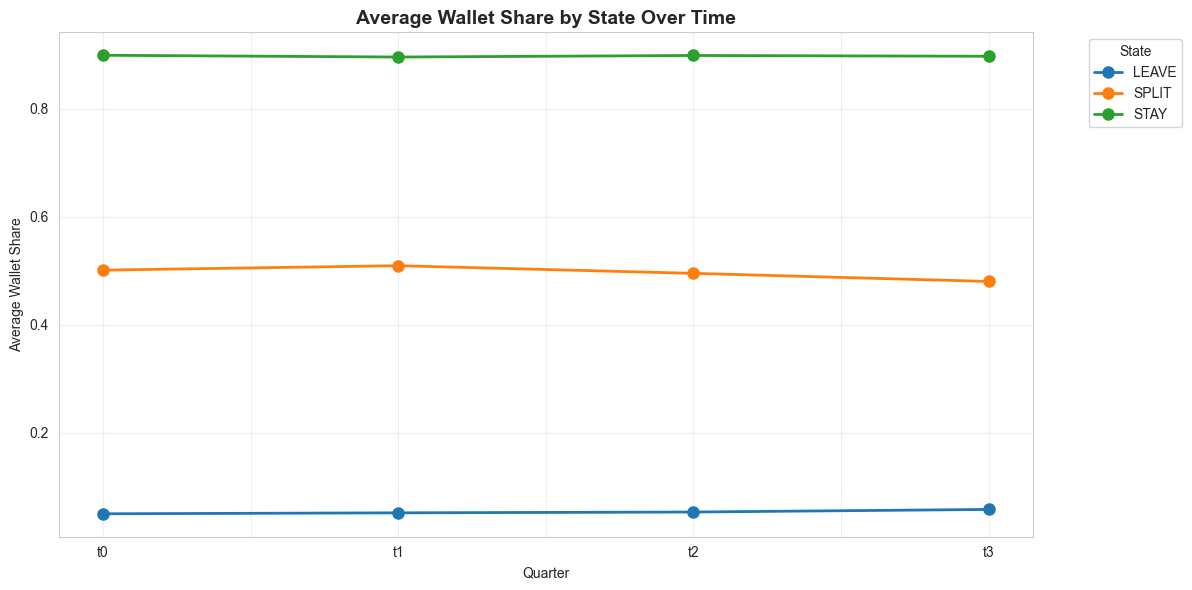

Average Wallet Share by Quarter and State
state    LEAVE  SPLIT  STAY
quarter                    
t0       0.050  0.501 0.899
t1       0.052  0.510 0.896
t2       0.054  0.495 0.899
t3       0.058  0.480 0.897


In [13]:
# Average wallet share over time
wallet_by_quarter = df.groupby(['quarter', 'state'])['wallet_share'].mean().unstack()

plt.figure(figsize=(12, 6))
wallet_by_quarter.plot(marker='o', linewidth=2, markersize=8)
plt.title('Average Wallet Share by State Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Average Wallet Share')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Average Wallet Share by Quarter and State")
print("="*40)
print(wallet_by_quarter.round(3))

## 6. Customer Segmentation Analysis

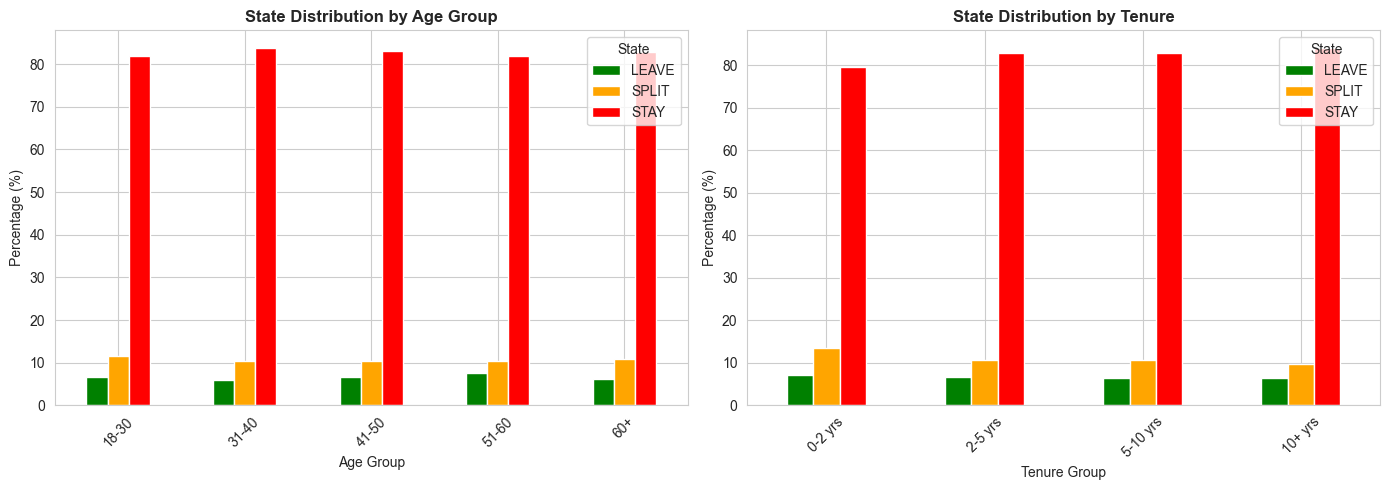

In [14]:
# Age groups analysis
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], 
                         labels=['18-30', '31-40', '41-50', '51-60', '60+'])

# State distribution by age group
age_state = pd.crosstab(df['age_group'], df['state'], normalize='index') * 100

# Tenure groups
df['tenure_group'] = pd.cut(df['tenure_years'], bins=[0, 2, 5, 10, 100], 
                            labels=['0-2 yrs', '2-5 yrs', '5-10 yrs', '10+ yrs'])

# State distribution by tenure
tenure_state = pd.crosstab(df['tenure_group'], df['state'], normalize='index') * 100

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

age_state.plot(kind='bar', ax=ax1, color=['green', 'orange', 'red'])
ax1.set_title('State Distribution by Age Group', fontsize=12, fontweight='bold')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Percentage (%)')
ax1.legend(title='State')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

tenure_state.plot(kind='bar', ax=ax2, color=['green', 'orange', 'red'])
ax2.set_title('State Distribution by Tenure', fontsize=12, fontweight='bold')
ax2.set_xlabel('Tenure Group')
ax2.set_ylabel('Percentage (%)')
ax2.legend(title='State')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

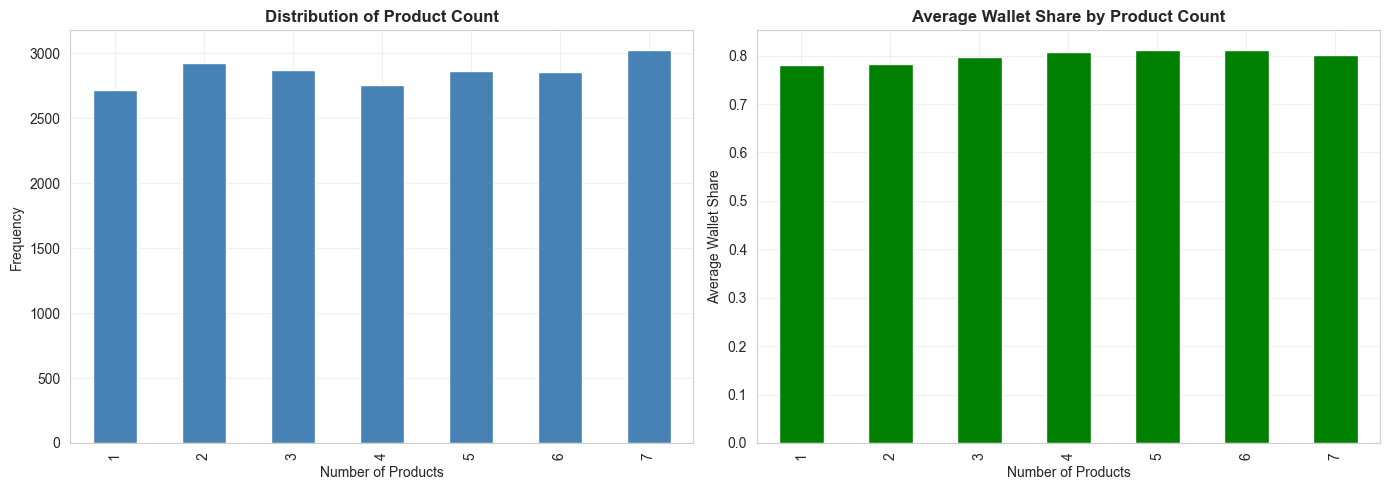

Product Count Analysis
               wallet_share  count
product_count                     
1                     0.780   2716
2                     0.782   2924
3                     0.798   2868
4                     0.807   2756
5                     0.811   2860
6                     0.811   2852
7                     0.802   3024


In [15]:
# Product holding patterns
product_analysis = df.groupby('product_count').agg({
    'wallet_share': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'count'})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Product count distribution
df['product_count'].value_counts().sort_index().plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Distribution of Product Count', fontsize=12, fontweight='bold')
ax1.set_xlabel('Number of Products')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Wallet share by product count
product_analysis['wallet_share'].plot(kind='bar', ax=ax2, color='green')
ax2.set_title('Average Wallet Share by Product Count', fontsize=12, fontweight='bold')
ax2.set_xlabel('Number of Products')
ax2.set_ylabel('Average Wallet Share')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Product Count Analysis")
print("="*40)
print(product_analysis.round(3))

## 7. Risk Indicators

In [16]:
# Identify at-risk customers (likely to leave)
at_risk = df[(df['state'] == 'STAY') & (df['next_state'] == 'LEAVE')]
stable = df[(df['state'] == 'STAY') & (df['next_state'] == 'STAY')]

print(f"At-risk customers (STAY -> LEAVE): {len(at_risk):,}")
print(f"Stable customers (STAY -> STAY): {len(stable):,}")
print(f"Risk rate: {len(at_risk) / (len(at_risk) + len(stable)) * 100:.2f}%")

# Compare features
risk_comparison = pd.DataFrame({
    'At Risk (STAY->LEAVE)': at_risk[key_features].mean(),
    'Stable (STAY->STAY)': stable[key_features].mean()
})
risk_comparison['Difference'] = risk_comparison['At Risk (STAY->LEAVE)'] - risk_comparison['Stable (STAY->STAY)']
risk_comparison['% Difference'] = (risk_comparison['Difference'] / risk_comparison['Stable (STAY->STAY)']) * 100

print("\nFeature Comparison: At-Risk vs Stable Customers")
print("="*60)
print(risk_comparison.round(2))

At-risk customers (STAY -> LEAVE): 141
Stable customers (STAY -> STAY): 15,428
Risk rate: 0.91%

Feature Comparison: At-Risk vs Stable Customers
                      At Risk (STAY->LEAVE)  Stable (STAY->STAY)  Difference  \
age                                  48.040               50.950      -2.910   
tenure_years                          5.730                6.040      -0.300   
product_count                         4.050                4.130      -0.080   
avg_balance                       30811.440            30549.230     262.210   
digital_engagement                    0.590                0.600      -0.010   
branch_visits_last_q                  1.940                1.800       0.140   
card_spend_monthly                 2604.200             2734.800    -130.600   

                      % Difference  
age                         -5.710  
tenure_years                -5.040  
product_count               -1.830  
avg_balance                  0.860  
digital_engagement          -

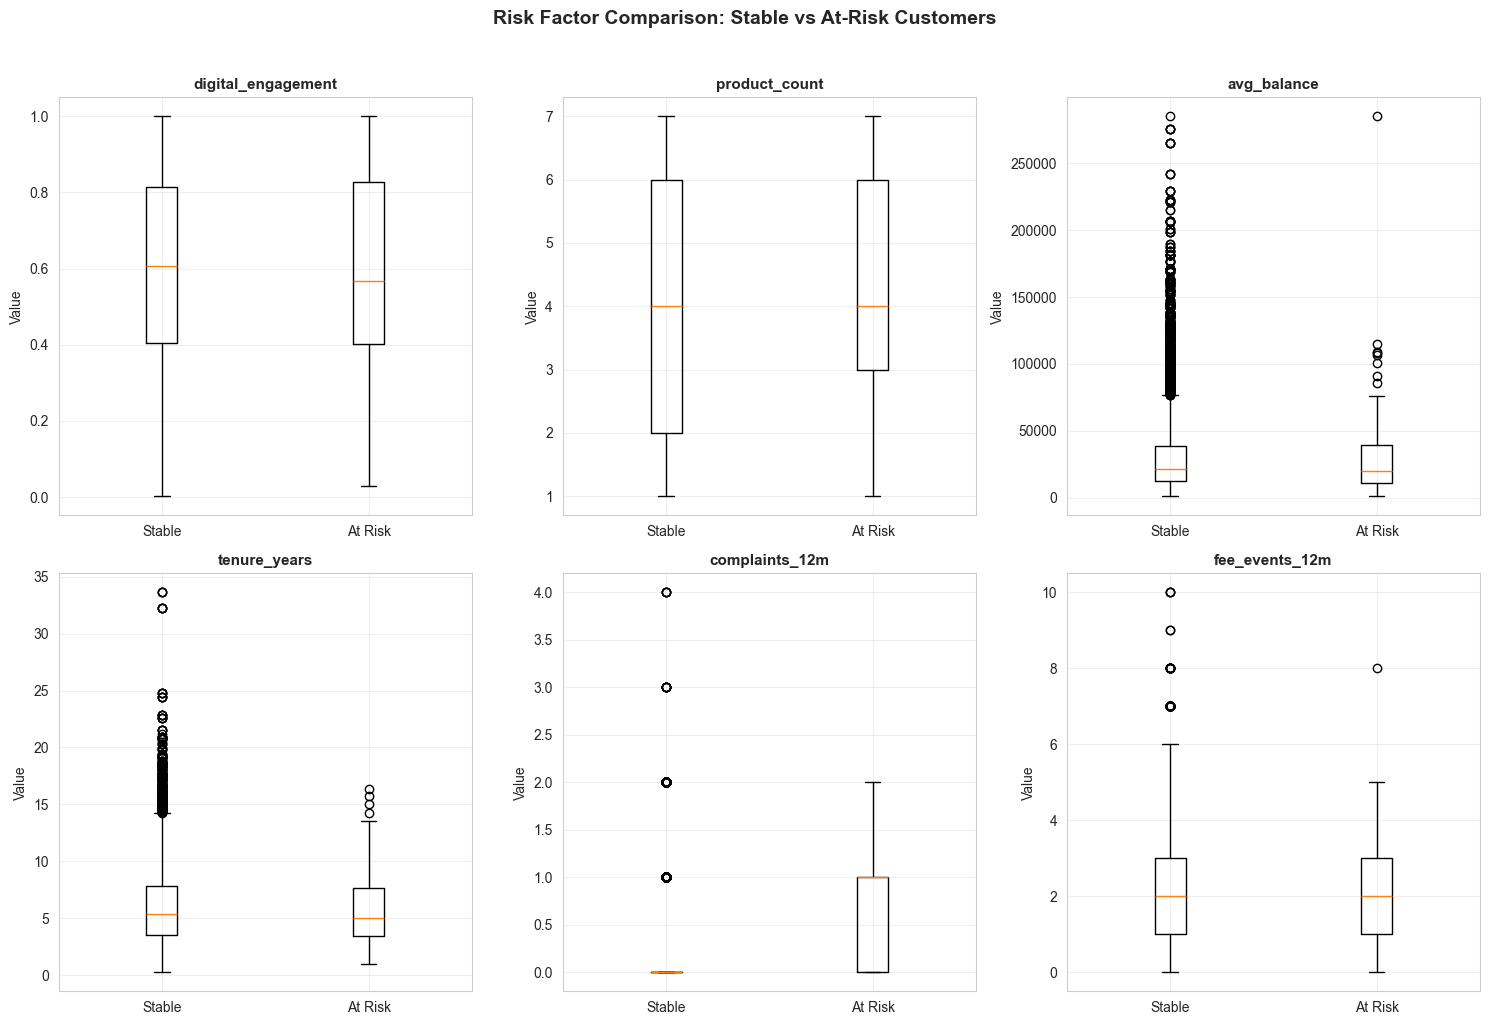

In [17]:
# Churn risk factors
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

risk_factors = ['digital_engagement', 'product_count', 'avg_balance', 
                'tenure_years', 'complaints_12m', 'fee_events_12m']

for i, factor in enumerate(risk_factors):
    ax = axes[i]
    
    # Box plot comparing at-risk vs stable
    data_to_plot = [stable[factor].dropna(), at_risk[factor].dropna()]
    ax.boxplot(data_to_plot, labels=['Stable', 'At Risk'])
    ax.set_title(f'{factor}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.suptitle('Risk Factor Comparison: Stable vs At-Risk Customers', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Key Insights and Next Steps

### Key Findings:
1. **State Distribution**: 
   - 82.6% STAY, 10.8% SPLIT, 6.6% LEAVE (current)
   - Positive trend: More STAY (89.2%) in next period

2. **Strong Retention**: 
   - STAY -> STAY: 96.0%
   - High wallet share retention for engaged customers

3. **Risk Indicators**:
   - Lower digital engagement
   - Fewer products
   - Higher complaints and fee events

4. **Positive Correlations with Wallet Share**:
   - Product count
   - Digital engagement
   - Average balance

### Next Steps:
1. Build Markov chain model with feature dependencies
2. Create wallet share forecasting model
3. Develop intervention scenarios
4. Build interactive prototype for testing

In [18]:
# Save processed data for modeling
df.to_csv('../data/processed/eda_enhanced.csv', index=False)
print("Enhanced dataset saved to: ../data/processed/eda_enhanced.csv")
print(f"Shape: {df.shape}")
print(f"New features added: age_group, tenure_group")

Enhanced dataset saved to: ../data/processed/eda_enhanced.csv
Shape: (20000, 22)
New features added: age_group, tenure_group
